In [367]:
# Import the necessary libraries
import wordcloud
import nltk
import textblob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib_inline
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import unicodedata
from spellchecker import SpellChecker
#import warnings
#warnings.simplefilter("ignore")


In [368]:
# Read in the file with the correct encoding
data = pd.read_csv('brandandproductemotions.csv', encoding='latin1')

# Display the first few rows of the data and rename colummns
data.columns = ['tweet', 'brand_og', 'target']

############## updated this to new scale for Textblob analysis
# rename target column values to simpler expressions
emotions = {'Negative emotion': 'negative','Positive emotion':'positive','No emotion toward brand or product':'neutral', 'I cant tell':'unknown'}
data['target'] = data['target'].map(emotions)
emotions = {'neutral':0, 'positive':1, 'negative':-1}
data['target'] = data['target'].map(emotions)

# Replace NaN with "unknown" in the 'brand_og' column
data['brand_og'].fillna('unknown', inplace=True)

# make all cells lower
data = data.applymap(lambda s: s.lower() if type(s) == str else s)

# key words to search for to ID brand
apple = ['iphone',
         'ipad',
         'itunes',
         'apple']
android = ['google',
           'samsung',
           'android']

##############
# Drop null in 'target' and 'tweet'
data = data.dropna(subset=['target', 'tweet'])



data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet     8936 non-null   object 
 1   brand_og  8936 non-null   object 
 2   target    8936 non-null   float64
dtypes: float64(1), object(2)
memory usage: 279.2+ KB


In [369]:
# function to create new brand column based on values in tweet
def check_substring(tweet):
    # check if any of the sub strings appear individually
    apple_list = any(substring in tweet for substring in apple)
    android_list = any(substring in tweet for substring in android)

    if apple_list and android_list:
        return "both"
    elif apple_list:
        return "apple"
    elif android_list:
        return "android"
    else:
        return "unkown"

data['new_brand'] = data['tweet'].apply(check_substring)

In [370]:
# Value counts for 'target'
#target_counts = data['target'].value_counts()
#print("Value counts for 'target':")
#print(target_counts)

# Value counts for 'analysis'
#analysis_counts = data['analysis'].value_counts()
#print("\nValue counts for 'analysis':")
#print(analysis_counts)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet      8936 non-null   object 
 1   brand_og   8936 non-null   object 
 2   target     8936 non-null   float64
 3   new_brand  8936 non-null   object 
dtypes: float64(1), object(3)
memory usage: 349.1+ KB


In [371]:
data['new_brand'].value_counts()

apple      5237
android    2727
unkown      716
both        256
Name: new_brand, dtype: int64

In [372]:
# drop android and unknown

#### LOOK AT REORDERING THIS IT DOESNT FLOW WELL RIGHT NOW
data_apple = data[~data['new_brand'].isin(['android', 'unknown'])]
print(data_apple.info())
print(data_apple['new_brand'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6209 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet      6209 non-null   object 
 1   brand_og   6209 non-null   object 
 2   target     6209 non-null   float64
 3   new_brand  6209 non-null   object 
dtypes: float64(1), object(3)
memory usage: 242.5+ KB
None
apple     5237
unkown     716
both       256
Name: new_brand, dtype: int64


In [373]:
data_apple['new_brand'].value_counts()

apple     5237
unkown     716
both       256
Name: new_brand, dtype: int64

def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", str(i))
        hashtags.append(ht)

    return hashtags

# Apply the hashtag_extract function to the 'tweet' column
data_apple['hashtags'] = data_apple['tweet'].apply(hashtag_extract)

# Now, the 'hashtags' column will contain a list of hashtags extracted from each tweet
print(data_apple[['tweet', 'hashtags']])

In [374]:

# DONE - Text Standardization: Convert all the text to a standard format, typically lowercase, to ensure uniformity across the entire dataset.

# DONE - Tokenization: Break the text into individual words or tokens. You can use libraries like NLTK (Natural Language Toolkit) or SpaCy for tokenization.

# DONE of URLs: Since URLs do not provide useful information for NLP tasks, it's recommended to remove them. This can be achieved using regular expressions.

# DONE - Removing @ mentions and Hashtags: The "@" mentions and "#" hashtags can be removed using regular expressions. Alternatively, you may want to replace them with the appropriate words that they are signifying. This can vary based on the specifics of your project.

# DONE - Removing Emoji and Emoticons: These can either skew your model (since they may not be present in your training set) or they could be turned into standardized text. For example, :) can be converted to the word 'smile'. You can use an emoji library for this purpose.

# DONE - Removing Punctuation: Punctuation can be removed using regular expressions or string manipulation functions.

# DONE - Stopwords Removal: Words such as "is", "and", "the", etc., are often removed as they usually do not carry much useful information. Libraries like NLTK and SpaCy have built-in lists of stopwords that can be used.

# DONE - Removing Numbers: Depending on the context, you might want to remove numbers. You can do this using regular expressions.

# DONE - Stemming or Lemmatization: This process involves reducing a word to its root form. For example, "running" is reduced to "run". Stemming can be a crude process, but it's faster. Lemmatization is more accurate but computationally more intensive.

# Handling Negations: Certain negation phrases like "not good", "isn't", "wasn't" etc. should be handled carefully. You may want to treat them as one term ("not_good", "is_not", "was_not") so that the sentiment isn't lost.

# NOT DONE YET - Spell Checking: This is particularly important for tweets as they often contain misspelled words. You can use a library like pyspellchecker for this.

# DONE - Removing Extra Whitespaces: Finally, make sure that there are no additional whitespaces in your text.

# Keep in mind that not all these steps will be necessary for every NLP task, and some may even be counterproductive. For example, in sentiment analysis, removing emojis could potentially remove useful sentiment information. Similarly, if you're doing an authorship attribution task, you might want to keep features like capitalization, as they can be indicative of individual writing styles. Therefore, the steps should be tailored to the specifics of your NLP task.


In [375]:
# Create a function that compiles all the steps taken above
#def preprocess(text):
#    '''
#    Processes text data by basic cleaning, tokenization, lemmatization, and stopwords removal.
#    '''
#    text = text.apply(lambda x: x.lower())
#    text = text.apply(lambda x: re.sub(r'([^A-Za-z0-9|\s|[:punct:]]*)', '', x))
#    text = text.apply(lambda x: x.replace('[^a-zA-Z#]', ' ').replace('quot', '').replace(':', '').replace('sxsw', ''))
#    text = text.apply(lambda x: ' '.join([i for i in x.split() if len(i)>3]))
#    text = text.apply(lambda x: x.split())
#    text = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
#    text = text.apply(lambda x: [word for word in x if word not in stopwords])
#    text = text.apply(lambda x: ' '.join(x))
#    return text

In [376]:
########## do we want this line of code: text.replace('[^a-zA-Z#]', ' ').replace('quot', '').replace(':', '').replace('sxsw', '')
########## text = "I am an AI developed by OpenAI"
########## becomes: developed OpenAI

def clean_tweet(text):
    # Remove hashtags (words starting with '#')
    text = re.sub(r'#\w+', '', text)
    
    # Handle RT tags
    text = re.sub(r'[Rr][Tt]', '', text)
    
    # Remove mentions (words starting with '@')
    text = re.sub(r'@\w+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove non-ASCII characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
        
    # Remove special characters and numbers not adjacent to text
    text = re.sub(r'\b\d+\b', '', text)

    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)     # Remove extra spaces
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_text = [word for word in text.split() if word not in stop_words]

    # Unique words to remove, add more as needed
    words_to_remove = ['Austin', 'Link', 'Sxsw', 'sxsw']

    for word in words_to_remove:
        cleaned_text = [w for w in cleaned_text if not re.match(r'\b{}\b'.format(word), w, flags=re.IGNORECASE)]

    return ' '.join(cleaned_text)


In [378]:
data_apple['cleaned_tweet'] = data_apple['tweet'].apply(clean_tweet)
data_apple['cleaned_tweet'].head(15)

TypeError: expected string or bytes-like object

In [366]:
type(data_apple['cleaned_tweet'])

pandas.core.series.Series

In [364]:
def tokenized_tweet(text):
    # Tokenize the cleaned tweet
    tknzr = TweetTokenizer()
    tokenized_tweet = tknzr.tokenize(text)

    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    tokenized_tweet = [lemmatizer.lemmatize(word) for word in tokenized_tweet]

    ##### takes an eternity to run
    # Apply optimized spell correction
    #tokenized_tweet = [optimized_spell_correction(word) for word in tokenized_tweet]

    return tokenized_tweet

In [365]:
data_apple['tokenized_tweet'] = data_apple['cleaned_tweet'].apply(lambda x: tokenized_tweet(x))
data_apple['tokenized_tweet'].head(15)

TypeError: expected string or buffer

In [ ]:
data_apple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6209 entries, 0 to 9091
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tweet          6209 non-null   object 
 1   brand_og       6209 non-null   object 
 2   target         6209 non-null   float64
 3   polarity       6209 non-null   float64
 4   subjectivity   6209 non-null   float64
 5   analysis       6209 non-null   int64  
 6   new_brand      6209 non-null   object 
 7   cleaned_tweet  6209 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 436.6+ KB


<ipython-input-268-2075732c0ba1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_apple['cleaned_tweet_str'] = data_apple['cleaned_tweet'].apply(lambda tokens: ' '.join(tokens))


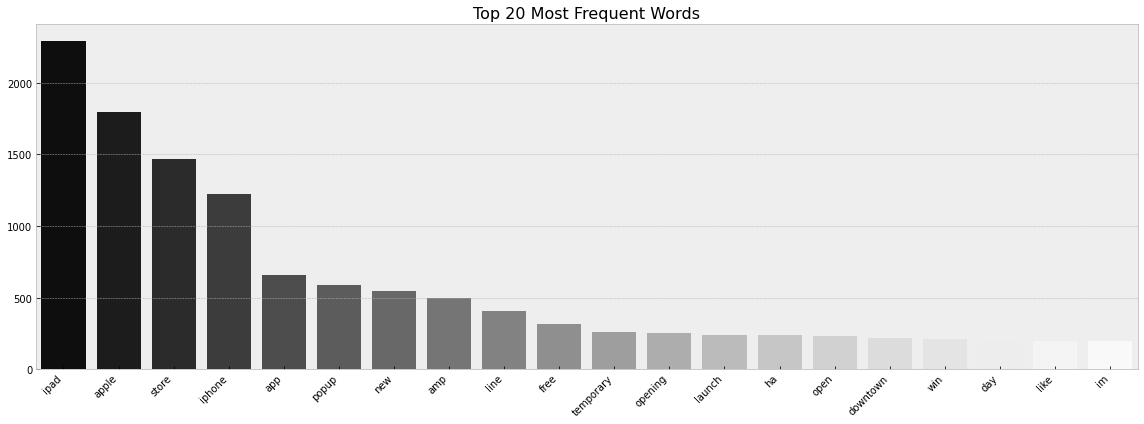

In [ ]:
# Convert tokenized tweets back to strings
data_apple['cleaned_tweet_str'] = data_apple['cleaned_tweet'].apply(lambda tokens: ' '.join(tokens))

# Initialize CountVectorizer with stop_words
cv = CountVectorizer(stop_words='english')

# Fit and transform the training data
X_counts = cv.fit_transform(data_apple['cleaned_tweet_str'])

# Rest of the code remains the same
# Get the word frequencies
sum_words = X_counts.sum(axis=0)
# Create a list of (word, frequency) tuples
frequencies = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
# Sort the frequencies in descending order
frequencies = sorted(frequencies, key=lambda x: x[1], reverse=True)
# Convert the list to a DataFrame
df_frequencies = pd.DataFrame(frequencies, columns=['word', 'frequency'])

# Plot the top 20 most frequent words
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='word', y='frequency', data=df_frequencies.head(20), palette='Greys_r')
ax.set_title('Top 20 Most Frequent Words', fontsize=16)
ax.set(xlabel=None, ylabel=None)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
data_apple.info()
#### How is it all back...I'm too tired

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6209 entries, 0 to 9091
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet              6209 non-null   object 
 1   brand_og           6209 non-null   object 
 2   target             6209 non-null   float64
 3   polarity           6209 non-null   float64
 4   subjectivity       6209 non-null   float64
 5   analysis           6209 non-null   int64  
 6   new_brand          6209 non-null   object 
 7   cleaned_tweet      6209 non-null   object 
 8   cleaned_tweet_str  6209 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 485.1+ KB


In [ ]:
########## FIGURE OUT WHERE TO DROP THE COLUMNS
##########  START HERE AND ADD WORD CLOUDS

In [ ]:
X = data_apple['cleaned_tweet']
y = data_apple['analysis']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

In [ ]:
##### NEXT GO HERE AND ADD TF_IDF WITH GRIDSEARCH

In [ ]:
##### ngram_range do we want to capture only singles and pairs of words???
##### the token_patern is only capturing words and not capturing 3g. do we want to add an expresion 
##### to capture words begining with a number?
##### can we grid search CountVectorizer for ngram_range???


# Convert tokenized tweets back to strings
X_train_pro_str = X_train_pro.apply(lambda tokens: ' '.join(tokens))
X_test_pro_str = X_test_pro.apply(lambda tokens: ' '.join(tokens))

# Create CountVectorizer with the specified token pattern and stop words
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=stop_words, ngram_range=[1, 2])

# Fit and transform the training data
X_train_vec = vec.fit_transform(X_train_pro_str)

# Transform the test data (only transform, don't fit again)
X_test_vec = vec.transform(X_test_pro_str)

NameError: name 'X_train_pro' is not defined

In [ ]:
new_df = pd.DataFrame(X_train_vec.toarray(), columns=vec.get_feature_names())
new_df.head()

,aa,aaaa,aapl,aaron,abacus,abba,abc,aber,ability,able,...,zite,zlf,zms,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
